# Feed-forward and backprop from scratch

### Take-home messages

* Non-linear activation functions in hidden layers are what makes neural networks as powerful as they are.
* Shapes are very important! If something isn't working, check that shapes of your variables make sense.
* Weights matrix for the layer N has dimensions (1 + # neurons in layer N, # neurons in layer N+1)
* You can think of a (fully connected feed-forward) neural network as many interconnected logistic regressions.
* Backprop is gradient descent on steroids.
* Log loss is a good loss function (its value is small when our model is doing well, and large when we have a poor model).

### Feed-forward

<div>
<img src="feedforward.png" width="500"/>
</div>

In [15]:
import matplotlib.pyplot as plt
import numpy as np

#### Step 1: Create training data

In [30]:
from sklearn.datasets import make_moons

In [31]:
X, y = make_moons(n_samples=50, noise=0.2, random_state=42)

In [32]:
X[0], y[0]

(array([-0.15856989,  0.98480618]), 0)

#### Step 2: Take a look at the data

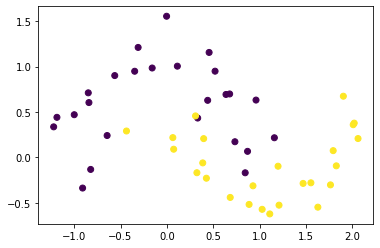

In [33]:
plt.scatter(X[:,0], X[:,1], c=y)

#### Step 3: Add a bias (parameter b) column to X

In [43]:
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

In [44]:
X = add_bias(X)

In [45]:
X.shape

(50, 3)

#### Step 4: calculate the sigmoid activation function

$$ \sigma(x) = \frac{1}{1+e^{-x}} $$

In [46]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [47]:
a = np.array([-10.0, -1.0, 0.0, 1.0, 10.0])
expected = np.array([0.0, 0.27, 0.5, 0.73, 1.0])
assert np.all(sigmoid(a).round(2) == expected)

#### Step 5: Initialize the weights

In [49]:
n_neurons = 2 # number of neurons in the hidden layer

In [50]:
w = []
w.append(np.random.randn(3, n_neurons)) # between innput and hidden
w.append(np.random.randn(n_neurons+1, 1)) # between hidden and output

#### Step 6: Put it all together

In [51]:
def feed_forward(X, weights):

    """
    1. Multiply the input matrix X (shape of (50, 3))
       with the weights of the first layer (shape of (3, 2)),
       resulting in the matrix of the shape (50, 2)
    """
    step1 = np.dot(X, weights[0]) 

    """    
    2. Apply the sigmoid function on the result,
       preserving the shape (50, 2) 
    """
    step2 = sigmoid(step1)
    
    """    
    3. Append an extra column of ones to the result (i.e. the bias),
       resulting in the shape (50, 3)
    """
    step3 = add_bias(step2)

    """    
    4. Multiply the output of the previous step (shape of (50, 3))
       with the weights of the second (i.e. outer) layer (shape of (3, 1)),
       resulting in the shape (50, 1)
    """
    step4 = np.dot(step3, weights[1])
    
    """    
    5. Apply the sigmoid function on the result, shape remains (50, 1)
    """
    step5 = sigmoid(step4)
    
    """    
    6. Return all intermediate results (i.e. anything that
       an activation function outputs).
    """

    return step2, step5

In [52]:
out1, out2 = feed_forward(X, w)
assert out1.shape == (50, 2)
assert out2.shape == (50, 1)

Xref = np.array([[1.0, 2.0, 1.0]])
whidden = np.array([[1.0, 2.0, 0.0],
                 [-1.0, -2.0, 0.0]
                    ]).T
wout = np.array([[1.0, -1.0, 0.5]]).T

out1, out2 = feed_forward(Xref, [whidden, wout])
assert np.all(out1.round(2) == np.array([[0.99, 0.01]]))
assert np.all(out2.round(2) == np.array([[0.82]]))

### Backpropagation

Brief gradient descent recap:

* To find the optimal model we need:
    * How well our model is doing — _loss function_
    * How to get from a bad model to a good model — _optmization algorithm_
* In linear regression:
    * Loss function is _MSE_
    * Optimization algorithm is _gradient descent_
* Here:
    * Loss function is _log loss_ (_binary cross-entropy_)
    * Optimization algorithm is (basically) still gradient descent.
* Gradient descent:
    $$ w_{new} = w_{old} - \alpha \nabla L(w) $$

<div>
<img src="neuron_w_backprop.png" width="500"/>
</div>

**Let's talk about loss function!**

* Here we'll use log loss as a loss function:
$$ loss = -(y_{true} log(y_{pred}) + (1-y_{true}) log(1-y_{pred})) $$

* Loss function tells us how our model is performing.
* In the backprop step (or when training a model), this is what we're minimizing.
* Here's how you can think of log loss:
    * If our label ($y_{true}$) is 1: 
    $$ loss = -log(y_{pred}) $$
        * If our prediction is close to zero, our model isn't doing very well. This is reflected in the loss function, because minus log of a small number is a "large" number.
        * If our prediction is close to 1, we have a good model. Our loss function (minus log of a number close to 1) is a small number — that checks out!
    * If our label is 0: 
    $$ loss = -log(1-y_{pred}) $$
        * You can follow the same line of reasoning and do this part as an exercise.
    

#### Step 1: Run feed-forward and make sure it works

Check!

#### Step 2: Write a Loss Function

##### 2a: Log-loss

$$ loss = -(y_{true} log(y_{pred}) + (1-y_{true}) log(1-y_{pred})) $$

In [53]:
def log_loss(ytrue, ypred):
    loss = -(ytrue*np.log(ypred)+(1-ytrue)*np.log(1-ypred)) 
    return loss

In [54]:
ytrue = np.array([0.0, 0.0, 1.0, 1.0])
ypred = np.array([0.01, 0.99, 0.01, 0.99])
expected = np.array([0.01, 4.61, 4.61, 0.01])
assert np.all(log_loss(ytrue, ypred).round(2) == expected)

##### 2b: Log-loss derivative

$$ loss' = -(\frac{y_{true}}{y_{pred}}-\frac{1-y_{true}}{1-y_{pred}}) $$

In [55]:
def log_loss_deriv(ytrue, ypred):
    loss_deriv = -(ytrue/ypred - (1-ytrue)/(1-ypred))  
    return loss_deriv

In [56]:
a = np.array([0.5, 0.3, 0.99, 0.2])
b = np.array([0.4, 0.2, 0.10, 0.3])
expected = np.array([-0.42, -0.62, -9.89, 0.48])
assert np.all(log_loss_deriv(a, b).round(2) == expected)

##### Extra — 2c: Sigmoid derivative

$$ \sigma' = \sigma (1-\sigma) $$

In [57]:
def sigmoid_deriv(X):
    return sigmoid(X)*(1-sigmoid(X))

#### Step 3: Calculate initial loss

In [59]:
out1, out2 = feed_forward(X, w)
ytrue = y.reshape(-1, 1)
loss = log_loss(ytrue, out2) #which arrays do we need to compare?

In [61]:
loss.shape

(50, 1)

In [62]:
[print(a, b, c) for (a, b, c) in zip(ytrue, out2, loss)]

[0] [0.84553832] [1.86780925]
[1] [0.88241412] [0.1250938]
[1] [0.85726256] [0.15401104]
[1] [0.92158827] [0.08165671]
[0] [0.82264273] [1.72958908]
[1] [0.92934256] [0.07327787]
[1] [0.83977683] [0.1746191]
[1] [0.82517634] [0.19215817]
[1] [0.85073411] [0.16165564]
[0] [0.81863791] [1.70725973]
[0] [0.85644161] [1.94101343]
[0] [0.89329017] [2.23764201]
[1] [0.9056968] [0.09905068]
[0] [0.8748026] [2.07786359]
[0] [0.87471913] [2.07719708]
[0] [0.85783329] [1.95075492]
[1] [0.9089755] [0.09543714]
[1] [0.92993529] [0.07264028]
[1] [0.92956917] [0.07303405]
[0] [0.83212135] [1.78451391]
[0] [0.87947986] [2.11593842]
[0] [0.84368501] [1.85588215]
[0] [0.80001114] [1.60949364]
[1] [0.86094223] [0.14972787]
[1] [0.85191946] [0.16026329]
[0] [0.8752417] [2.08137699]
[1] [0.91688311] [0.08677528]
[1] [0.84175859] [0.17226202]
[1] [0.87861015] [0.129414]
[0] [0.87734081] [2.09834558]
[1] [0.85707403] [0.15423098]
[0] [0.8742962] [2.0738269]
[1] [0.87754603] [0.13062587]
[0] [0.88052828] [2.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Step 4: Write a backpropagation function

<div>
<img src="backprop_equations.png" width="400"/>
</div>

In the above we have: 
- $\cdot$ is a **dot product**
- $\times$ is **regular multiplication**
- $\nabla$ is a **gradient**
- $\Delta$ is a **delta** or **change in**

Fill in the blanks of the following function, which transcribes the equations from earlier (equations A - E) to run one iteration of the backpropagation algorithm. It takes in a handful of arguments:
* the initial weights,
* the outputs from the feed-forward process (i.e. both the hidden output and the final output),
* the true labels,
* the input data,
* and the learning rates (we’ll have a separate learning rate for each layer of the network).

The function (representing a single iteration of the backpropagation algorithm), should return the modified hidden weights and the modified outer weights.

In [ ]:
def backprop(weights,
             output1,
             output2,
             ytrue,
             X_input,
             LR):

    wH = weights[0]
    wO = weights[1]

    '''EQUATION A:'''
    error = log_loss_deriv(___ , ___)

    '''EQUATION B:'''
    # don't forget the bias!
    hidden_out_with_bias = add_bias(___)
    # derivative of the sigmoid function with respect to the
    # hidden output * weights
    sig_deriv_1 = sigmoid_deriv(___)

    y_grad = sig_deriv_1 * error

    '''EQUATION C:'''
    delta_wo = -np.dot(___.T, hidden_out_with_bias) * LR

    #and finally, old weights + delta weights -> new weights!
    wO_new = wO + ___.T

    '''EQUATION D:'''
    sig_deriv_2 = sigmoid_deriv( ___ )
    #exclude the bias (last column) of the outer weights,
    #since it is not backpropagated!
    H_grad = ___  * np.dot(y_grad , ___[:-1].T)

    '''EQUATION E:'''
    delta_wH = -np.___(H_grad.T, ___ ) * ___
    #old weights + delta weights -> new weights!
    wH_new = wH + ___.T

    # new hidden weights, new output weights
    return ___, ___

In [63]:
def backprop(weights,
             output1,
             output2,
             ytrue,
             X_input,
             LR):

    wH = weights[0]
    wO = weights[1]

    '''EQUATION A:'''
    error = log_loss_deriv(ytrue, output2)
    
    '''EQUATION B:'''
    #don't forget the bias!
    hidden_out_with_bias = add_bias(output1)
    #derivative of the sigmoid function with respect to the
    #hidden output * weights
    sig_deriv_1 = sigmoid_deriv(hidden_out_with_bias.dot(wO))
    y_grad = sig_deriv_1 * error

    '''EQUATION C:'''
    delta_wO = -np.dot(y_grad.T, hidden_out_with_bias) * LR

    #and finally, old weights + delta weights -> new weights!
    wO_new = wO + delta_wO.T

    '''EQUATION D:'''
    sig_deriv_2 = sigmoid_deriv(X_input.dot(wH))
    #exclude the bias (last column) of the outer weights,
    #since it is not backpropagated!
    H_grad = sig_deriv_2 * np.dot(y_grad , wO[:-1].T)
    
    '''EQUATION E:'''
    delta_wH = -np.dot(H_grad.T, X_input) * LR
    #old weights + delta weights -> new weights!
    wH_new = wH + delta_wH.T
    
    # new hidden weights, new output weights
    return wH_new, wO_new

#### Step 5: Run the Backpropagation Algorithm

Run your backpropagation algorithm in a loop! Inside the loop:
* Run your feed-forward function with the X data and the starting weights (which are initially random!).
* Collect the total sum of the log-loss values into a list, so we can track them over time.
* Run your backprop function to get the modified weights.
* At the end of the loop, make your modified weights the new weights for the next cycle.

In [ ]:
# setup
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
X = add_bias(X)
y = y.reshape(-1, 1)
weights = [
   np.random.normal(size=(3, 2)),
   np.random.normal(size=(3, 1))
]

# train
LOSS_VEC = []

for i in range(1000):
    out1, out2 = feed_forward(X, weights)
    LOSS_VEC.append(___.sum())
    new_weights = backprop(___, ___, ___, ___, ___, ___)
    weights = ___

In [84]:
# - increase the number of neurons to see how the performance of your NN changes
# - change the value for learning rate in backprop to see how your model performance changes

LR = 0.01
n_neurons = 15
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X = add_bias(X)
y = y.reshape(-1, 1)
weights = [
   np.random.randn(3, n_neurons),
   np.random.randn(n_neurons+1, 1)
]

# train
LOSS_VEC = []

for i in range(1000):
    out1, out2 = feed_forward(X, weights)
    LOSS_VEC.append(log_loss(y, out2).sum())
    new_weights = backprop(weights, out1, out2, y, X, LR)
    weights = new_weights

#### Step 6: Plot results

##### 6a: Plot loss function

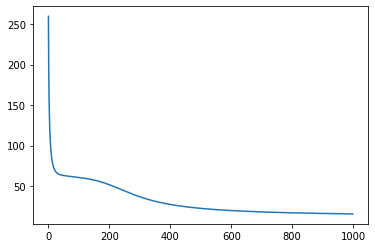

In [85]:
plt.plot(LOSS_VEC)

How does the loss function sum change as we increase number of neurons:
* 2 neurons: final loss (sum) is ~60.
* 5 neurons: final loss (sum) is ~30.
* 10 neurons: final loss (sum) is ~20.
* 15 neurons: final loss (sum) is ~15.

##### 6b: Plot decision boundary

In [81]:
# create a grid of values
x = np.linspace(-3, 3, 200)
X_vis = np.array([(x1, x2) for x1 in x for x2 in x])
# add the bias column
X_vis = add_bias(X_vis)

# calculate the (random) predictions
_, y_pred = feed_forward(X_vis, weights)

In [82]:
# reshape the predictions for visualization
Z = y_pred.reshape((len(x), len(x)), order='F')

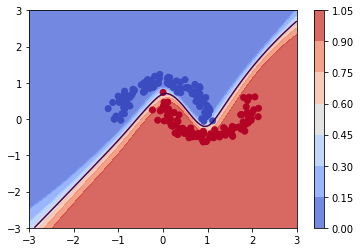

In [83]:
# draw a contour plot
fig,ax=plt.subplots(1,1)
cp = ax.contourf(x, x, Z, alpha=0.8, cmap='coolwarm')
ax.contour(x, x, Z, levels=[0.5])
fig.colorbar(cp) # Add a colorbar to a plot

# draw the original data
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')

### Appendix. MATH

#### Equation A. Calculate the derivative of the loss function


$$error = loss'(ytrue, ypred)$$

The error variable is in fact the derivative of the loss function.

$$\frac{\partial L}{\partial O_{out}} = -(\frac{y}{ypred}-\frac{1-y}{1-ypred})$$

In gradient descent we calculated the gradient of the MSE to minimise it step by step. Backpropagation works with the same principle but in this case we are using the log loss as the loss function and calculating its derivative.

#### Equation B. Calculate the derivative of the activation function

The derivative of the activation function will contribute to the gradient of the cost function.

$$\nabla y = act'(H_O \cdot w_O) \times error$$  

It comes from the below usage of chain rule.

$$ \frac{\partial L}{\partial O_{in}} =\frac{\partial L}{\partial O_{out}} \cdot \frac{\partial O_{out}}{\partial O_{in}} $$

Where:

$$\frac{\partial O_{out}}{\partial O_{in}} = act'(O_{in}) = act'(H_O \cdot w_O) $$

#### Equation C. Calculate weight change between 2 layers

The adjustment in the weights is proportional to the negative of the loss gradient. Recall: we multiply the negative of the loss gradient by some small constant that we call the **learning rate** to determine the step size.


$$\Delta{w_O} = -( \frac{\partial L}{\partial O_{in}} \cdot \frac{\partial O_{in}}{\partial w_O}) \times LR $$

or

$$\Delta w_O = -(\nabla y \cdot H_{out}) \times LR$$

where 

$$H_{out}=\frac{\partial O_{in}}{\partial w_O}$$

The updated weights are and the next weight at this layer will be:

$$ w_{new} = w_{old} + \Delta w_O$$

#### Equation D.

Here we are repeating a similar process to step B for our first (hidden) layer with 2 neurons.

So, we can write the full equation as:

$$ \frac{\partial L}{\partial H_{in}} = (\frac{\partial L}{\partial O_{in}}\cdot \frac{\partial O_{in}}{\partial H_{out}}) \times \frac{\partial H_{out}}{\partial H_{in}} $$

where 

$$\frac{\partial H_{out}}{\partial H_{in}} = act'(X \cdot w_H) $$

and

$$\frac{\partial O_{in}}{\partial H_{out}} = w_O$$


Final equation becomes:



$$ \frac{\partial L}{\partial H_{in}} = (\frac{\partial L}{\partial O_{in}}  \cdot w_O)\times \frac{\partial H_{out}}{\partial H_{in}} $$


Or for our purposes:

$$\nabla H =  (\nabla y \cdot w_O) \times act'(X \cdot w_H)$$

#### Equation E. Calculate change in the first set of weights

Repeating step C for the first layer with 2 neurons.

The adjustment in the weights is proportional to the negative of the loss gradient.

$$\Delta w_H = -(\nabla H \cdot X) \times LR$$

where

$$\frac{\partial H_{in}}{\partial w_H} = X$$

The change in weights are 

$$\Delta w_H = -( \frac{\partial L}{\partial H_{in}} \cdot X) \times LR $$

And the next weight at this layer will be:

$$ w_{H_{new}} = w_H + \Delta w_H$$